In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imp import reload
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression as LR

from cca import ComplexityComponentsAnalysis as CCA
from cca import methods_comparison as mc
from cca import synth_data

# Comparison with PCA

From an analysis perspective, the goal of PCA is to find the subspace that maximizes the projected variance of the data. If the dimensions with dynamics have low variance compared to the noise dimensions, PCA will not recover the dynamics.

Here, we show this on a dataset where the first two dimensions are GPs with different kernels and kernel parameters and variance=1. The second two dimensions are multivariate noise with variances 5 and 2 respectively.

In [9]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.01)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('exp', spatial_scale=2., temporal_scale=5., local_noise=.01)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
X3 = np.random.multivariate_normal([0., 0.], [[5., 0.], [0., 2]], size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [10]:
pca = PCA(n_components=2).fit(X)
print(pca.components_.T)
print(subspace_angles(proj, pca.components_.T))

[[-0.01975814 -0.0494304 ]
 [ 0.00652226 -0.04176741]
 [ 0.99937504  0.02781839]
 [-0.02857622  0.99751604]]
[1.55332572 1.50505565]


In [11]:
cca = CCA(d=1, T=5, n_init=5).fit(X)
print(cca.coef_)

cca = CCA(d=2, T=5, n_init=5).fit(X)
print(cca.coef_)
print(subspace_angles(proj, cca.coef_))

[[-9.99699859e-01]
 [-2.37229462e-02]
 [-6.15632145e-04]
 [ 6.08555600e-03]]
[[-0.69720996  0.71684462]
 [-0.71678437 -0.69721285]
 [-0.00618422 -0.00522636]
 [ 0.00895535  0.00085005]]
[0.01155688 0.00359508]


# Comparison to SFA
SFA is only sensitive to the autocorrelation at one time-lag wheras DCA is sensitive to all auto and crosscorrelations at up to 2T time-lags.

In [2]:
T = 50
noise = .0001
taus = np.linspace(.9, 1., 100)
gauss_pi = np.zeros_like(taus)
exp_pi = np.zeros_like(taus)
gauss_ac1 = np.zeros_like(taus)
exp_ac1 = np.zeros_like(taus)

In [3]:
for ii, tau in enumerate(taus):
    gauss_k = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    exp_k = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
    gauss_cov = synth_data.gen_gp_cov(T, 1, gauss_k)
    exp_cov = synth_data.gen_gp_cov(T, 1, exp_k)
    gauss_ac1[ii] = gauss_cov[0, 1]
    exp_ac1[ii] = exp_cov[0, 1]
    gauss_pi[ii] = synth_data.calc_pi_for_gp(T, 1, gauss_k)
    exp_pi[ii] = synth_data.calc_pi_for_gp(T, 1, exp_k)

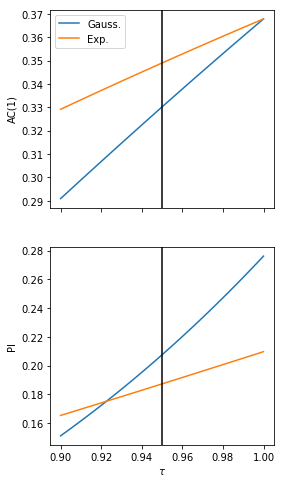

In [4]:
tau = .95
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(4, 8))
ax1.plot(taus, gauss_ac1, label='Gauss.')
ax1.plot(taus, exp_ac1, label='Exp.')
ax1.set_ylabel('AC(1)')
ax1.axvline(tau, 0, 1, c='k')
ax1.legend(loc='best')

ax2.plot(taus, gauss_pi)
ax2.plot(taus, exp_pi)
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel('PI')
ax2.axvline(tau, 0, 1, c='k')

In [10]:
n_samples = 1000
GP1_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
GP2_ker = synth_data.gen_gp_kernel('exp', spatial_scale=1, temporal_scale=tau, local_noise=noise)
X1 = synth_data.sample_gp(n_samples, 1, GP1_ker, num_to_concat=10) * 2.
X2 = synth_data.sample_gp(n_samples, 1, GP2_ker, num_to_concat=10)
#X2 = np.random.randn(n_samples, 1)
X = np.concatenate([X1, X2], axis=1)

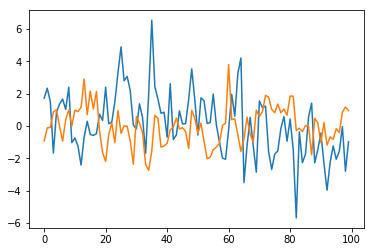

In [11]:
plt.plot(X1[:100])
plt.plot(X2[:100])

In [12]:
reload(mc)
sfa_model = mc.SlowFeatureAnalysis(1).fit(X)
print(sfa_model.coef_)

[[-0.01350397]
 [-0.99990882]]


In [13]:
cca_model = CCA(d=1, T=1, n_init=5).fit(X)
print(cca_model.coef_)

[[-0.01163168]
 [-0.99993235]]


In [19]:
cca_model = CCA(d=1, T=2, n_init=5).fit(X)
print(cca_model.coef_)

[[0.99559477]
 [0.09376066]]


# Comparison with GPFA

In [68]:
n_samples = 1000
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=3., local_noise=.001)
X1 = synth_data.sample_gp(n_samples, 1, GP_ker)
GP_ker = synth_data.gen_gp_kernel('squared_exp', spatial_scale=2., temporal_scale=10., local_noise=.001)
X2 = synth_data.sample_gp(n_samples, 1, GP_ker)
mu = np.zeros(4)
cov = np.diag([4, 3, 2, 1])
X3 = np.random.multivariate_normal(mu, cov, size=n_samples)
X = np.concatenate([X1, X2, X3], axis=1)
proj = np.zeros((X.shape[1], 2))
proj[0, 0] = 1
proj[1, 1] = 1

In [ ]:
reload(mc)

gpfa = mc.GaussianProcessFactorAnalysis(n_factors=2, verbose=True, max_iter=10)
gpfa.fit(X)

cca_model = CCA(d=2, T=5, n_init=5).fit(X)

FA log likelihood: -11343.761604049589
Pre update log likelihood: -11343.761604049589
C_ update log likelihood: -11220.358655964686


In [ ]:
print(gpfa.C_)
print(gpfa.R_)
print(gpfa.d_)
print(gpfa.tau_)

In [ ]:
print(gpfa.C_)
print(subspace_angles(proj, gpfa.C_))
model = LR().fit(X[:, :2], gpfa.transform(X))
model.score(X[:, :2], gpfa.transform(X))

In [ ]:
print(cca_model.coef_)
print(subspace_angles(proj, cca_model.coef_))
model = LR().fit(X[:, :2], cca_model.transform(X))
model.score(X[:, :2], cca_model.transform(X))